In [2]:
!pip install cirq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 594 kB 6.4 MB/s 
     |████████████████████████████████| 1.8 MB 72.4 MB/s 
     |████████████████████████████████| 66 kB 5.2 MB/s 
     |████████████████████████████████| 57 kB 5.6 MB/s 
     |████████████████████████████████| 577 kB 104.5 MB/s 
     |████████████████████████████████| 120 kB 101.2 MB/s 
     |████████████████████████████████| 221 kB 83.0 MB/s 
     |████████████████████████████████| 229 kB 96.9 MB/s 
     |████████████████████████████████| 44 kB 3.3 MB/s 
     |████████████████████████████████| 147 kB 80.7 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 69 kB 8.3 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 119 k

In [4]:
import cirq
import math
from cirq.contrib.svg import SVGCircuit
import sympy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import genfromtxt

In [5]:
## DEFINITION
N = 8
D=3
A = 0.03
##sigma=np.zeros((N,N))
# sigma = np.array([[9.980e-05, 4.250e-05, 3.720e-05, 4.030e-05],
#                   [4.250e-05, 1.005e-04, 4.110e-05, 1.520e-05],
#                   [3.720e-05, 4.110e-05, 1.813e-04, 1.790e-05],
#                   [4.030e-05, 1.520e-05, 1.790e-05, 2.531e-04]])
# mu = np.array([4.01e-04,  6.10e-05,  9.16e-04, -6.19e-04])
sigma = genfromtxt('Sigma.csv', delimiter=',')
mu = np.array([ 0.27639461,  0.35676064,  0.30267724, -0.0343477,   0.05617082, -0.05095225,
 -0.03738396,  0.83449729])
y = np.zeros(N)
qubits = [cirq.LineQubit(i) for i in range(2*N)]
L=len(qubits)
index_grid_pair = [(2*i,2*i+1) for i in range(0,N) ]

lam=0.9

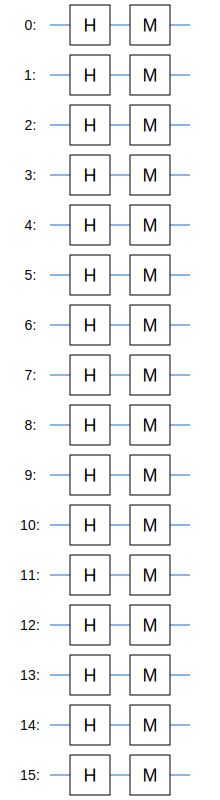

In [6]:
hadamard=cirq.Circuit()
measurements=cirq.Circuit()
for i in range(L):
    hadamard.append(cirq.H(qubits[i]))
    measurements.append(cirq.measure(qubits[i]))

circuit = cirq.Circuit((hadamard,measurements))

#print(circuit)
SVGCircuit(circuit)

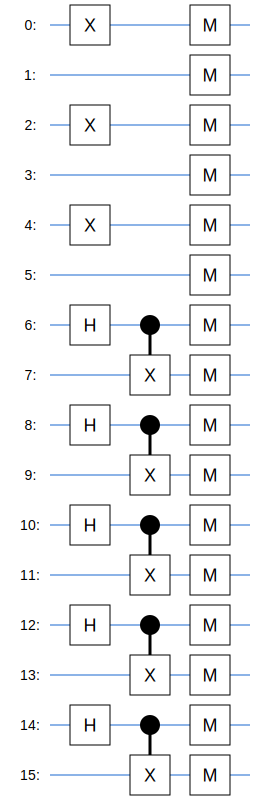

In [7]:
##INITIALIZATION_HARD AND MEASURE        
initial_hard = cirq.Circuit()
for i in range(int(D)):
        initial_hard.append(cirq.X(qubits[index_grid_pair[i][0]]))
for i in range(int(D), N):
                initial_hard.append(cirq.H(qubits[index_grid_pair[i][0]]))
                initial_hard.append(cirq.CNOT(qubits[index_grid_pair[i][0]], qubits[index_grid_pair[i][1]]))

circuit=cirq.Circuit(initial_hard, measurements)
     
SVGCircuit(circuit)

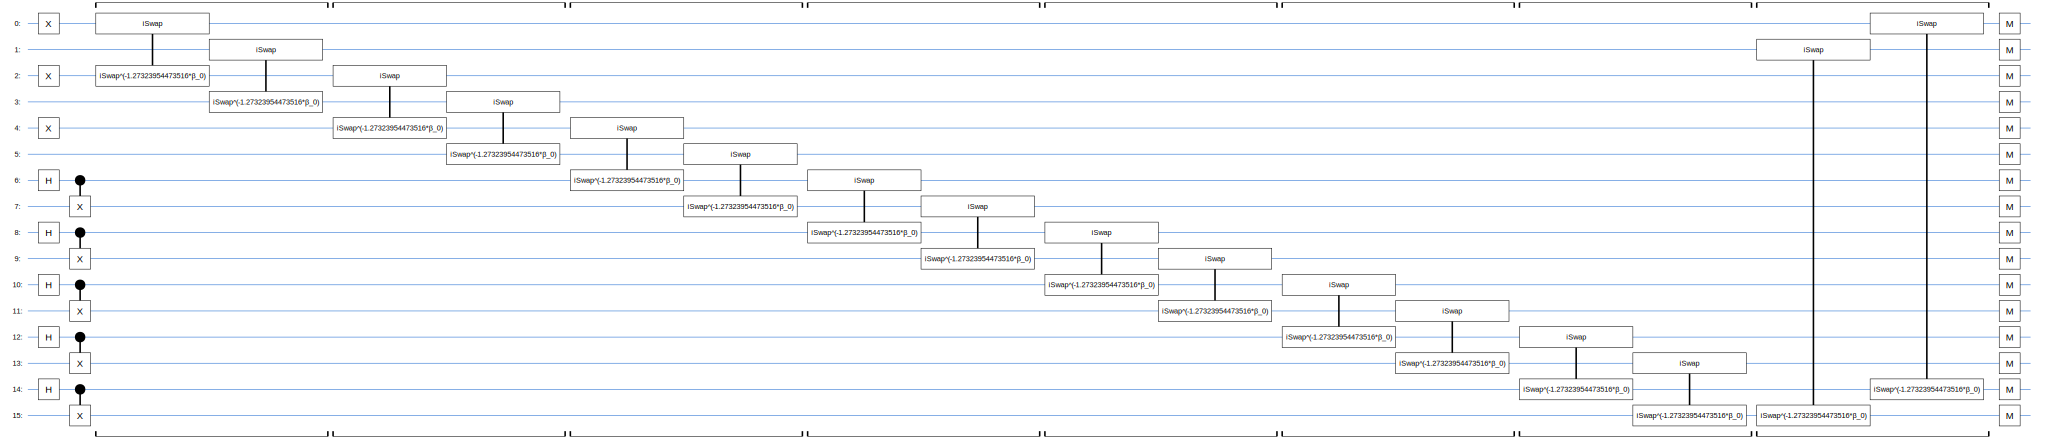

In [8]:
## Mixer Hard 
beta_list = ["β_"+str(i) for i in range(1)]
betas = sympy.symbols(beta_list)
mixer_hard = cirq.Circuit()

for i in range(0,2*N-2,2):
    mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-betas[0])/np.pi)).on(qubits[i],qubits[i+2]))
    
for i in range(1,2*N-2,2):
    mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-betas[0])/np.pi)).on(qubits[i],qubits[i+2]))

mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-betas[0])/np.pi)).on(qubits[2*N-1],qubits[1]))
mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-betas[0])/np.pi)).on(qubits[2*N-2],qubits[0]))

circuit = cirq.Circuit(initial_hard,mixer_hard,measurements)
SVGCircuit(circuit)

In [12]:
##INITIALIZATION_HARD AND MEASURE
def circuit_hard():
    initial_hard = cirq.Circuit()
    # Initialising the first D = N/2 qubits in |10> state (s+ being the first qubit and s- being the 2nd)
    for i in range(int(D)):
            initial_hard.append(cirq.X(qubits[index_grid_pair[i][0]]))
    # Initialising the remaining N-D qubits in the |phi_00> state
    for i in range(int(D), N):
                    initial_hard.append(cirq.H(qubits[index_grid_pair[i][0]]))
                    initial_hard.append(cirq.CNOT(qubits[index_grid_pair[i][0]], qubits[index_grid_pair[i][1]]))
    return initial_hard

## INITIALIZATION AND MEASURE
def circuit_hadamard():  #Introduces a H gate on every qubit (L=2N)
    hadamard=cirq.Circuit()
    for i in range(L):
        hadamard.append(cirq.H(qubits[i]))
    return hadamard

def circuit_measurements(): #Introduces a measurement operator on every qubit (L=2N)
    measurements=cirq.Circuit()
    for i in range(L):
        measurements.append(cirq.measure(qubits[i]))
    return measurements

## MIXER OPERATOR
def circuit_mixer(beta): #Introduces a mixer operator (rotation of 2*beta) on every qubit (L=2N)
    mixer=cirq.Circuit()
    for i in range(L):
        mixer.append(cirq.rx(2*beta).on(qubits[i]))
    return mixer

def circuit_mixer_hard(beta):
    mixer_hard = cirq.Circuit()
    # Even parity mixer bands Ref: Fig-1 of paper
    for i in range(0,2*N-2,2):
        mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-beta)/np.pi)).on(qubits[i],qubits[i+2])) 
    # Odd parity mixer bands Ref: Fig-1 of paper
    for i in range(1,2*N-2,2):
        mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-beta)/np.pi)).on(qubits[i],qubits[i+2]))
    # Long position parity mixer Ref: Fig-1 of paper
    mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-beta)/np.pi)).on(qubits[2*N-1],qubits[1]))
    # Short position parity mixer Ref: Fig-1 of paper
    mixer_hard.append(cirq.ISwapPowGate(exponent=(4.0*(-beta)/np.pi)).on(qubits[2*N-2],qubits[0]))
    return mixer_hard

## RETURNS OPERATOR
def circuit_returns(gamma): # Implements the returns operator (L=2N)
    returns=cirq.Circuit()
    for i in range(L):
        returns.append(cirq.rz((-1)**int(i)*(1-lam)*gamma*mu[int(i/2)]).on(qubits[i]))
    return returns

## RISK OPERATOR
def circuit_risk(gamma):  #Implements the risk operator (L=2N)
    combinations=[]
    for i in range(L):
        for j in range(L):
            if i!=j:
                combinations.append((i,j))
    numcombinations=len(combinations)
    risk=cirq.Circuit()
    for i in range(numcombinations):
        q1=combinations[i][0]
        q2=combinations[i][1]
        ii=math.floor(q1/2)
        jj=math.floor(q2/2)
        sign=-(-1)**((q1 % 2)+(q2 %2))
        risk.append(cirq.ZZPowGate(exponent= 1/2*sign*gamma*lam*sigma[ii][jj]).on(qubits[q1],qubits[q2]))
    return risk

##  CONSTRAINT OPERATOR
def circuit_constraint(gamma): #Implement the constraint operator (both linear and quadratic terms) (L=2N)
    combinations=[]
    for i in range(L):
        for j in range(L):
            if i!=j:
                combinations.append((i,j))
    numcombinations=len(combinations)
    constraint=cirq.Circuit()
    for i in range(len(qubits)):
        sign=(-1)**i
        constraint.append(cirq.rz( sign *2 *gamma*A*D).on(qubits[i]))
    for i in range(numcombinations):
        q1=combinations[i][0]
        q2=combinations[i][1]
        sign=-(-1)**((q1 % 2)+(q2 %2))
        constraint.append(cirq.ZZPowGate(exponent= 1/2*sign*A*gamma).on(qubits[q1],qubits[q2]))
    return constraint

## CIRCUIT BUILDER
def circuit_builder(beta,gamma):  #Creates a circuit of depth 1 with beta and gamma the parameters of the cost hamiltonian and mixer
    hadamard=circuit_hadamard()
    returns=circuit_returns(gamma)
    risk=circuit_risk(gamma)
    constraint=circuit_constraint(gamma)
    mixer=circuit_mixer(beta)
    measurements=circuit_measurements()
    return cirq.Circuit(hadamard, returns, risk, constraint, mixer, measurements)

def circuit_builder_p(beta,gamma): #Creates a circuit of depth p (beta and gamma must be arrays of length p)
    if len(beta)==len(gamma):
        p=len(beta)
    else:
        print("Error: beta and gamma must have the same length")
        return 1;
    circuit=cirq.Circuit()
    circuit.append(circuit_hadamard())
    for i in range(p):
        circuit.append(circuit_returns(gamma[i]))
        circuit.append(circuit_risk(gamma[i]))
        circuit.append(circuit_constraint(gamma[i]))
        circuit.append(circuit_mixer(beta[i]))
    circuit.append(circuit_measurements())
    return circuit

def circuit_builder_p_hard(beta,gamma): #Creates a circuit of depth p (beta and gamma must be arrays of length p)
    if len(beta)==len(gamma):
        p=len(beta)
    else:
        print("Error: beta and gamma must have the same length")
        return 1;
    circuit=cirq.Circuit()
    circuit.append(circuit_hard())
    for i in range(p):
        circuit.append(circuit_returns(gamma[i]))
        circuit.append(circuit_risk(gamma[i]))
        circuit.append(circuit_mixer_hard(beta[i]))
    circuit.append(circuit_measurements())
    return circuit

## COST FUNCTION
def cost_function(z): #Computes the cost function for a given position (ex (z=[1,,0,-1,1]))
    return lam*np.dot(z,np.dot(sigma,z))+A*(D-sum(z))**2-(1-lam)*np.dot(mu,z)

def cost_function_angle(beta,gamma,numsim): #Computes the minumum cost function for given angles beta and gamma and a number of simulations
    simulator = cirq.Simulator()
    Cost_min=100
    circuit=circuit_builder(beta,gamma)
    for i in range(numsim):
        result = simulator.run(circuit)
        list=[]
        z=[]
        for value in result.measurements.values():
            list.append(value[0,0])
        for i in range(N):
            z.append((list[2*i]-list[2*i+1]))
        C=cost_function(z)
        if C<Cost_min:
            Cost_min=C
    return Cost_min

## GRID SEARCH
def grid_search(numpoints, numsim): # Inputs: number of values of beta and gamma // Outputs: best position, minimum cost function
    Cost_min=100
    simulator = cirq.Simulator()
    positions=[]
    betas= np.linspace(0, 2 * np.pi, numpoints)
    gammas= np.linspace(0, 2 * np.pi, numpoints)
    for beta in betas:
        for gamma in gammas:
            circuit=circuit_builder(beta,gamma)
            for i in range(numsim):
                result = simulator.run(circuit)
                list=[]
                z=[]
                for value in result.measurements.values():
                    list.append(value[0,0])
                for i in range(N):
                    z.append((list[2*i]-list[2*i+1]))
                C=cost_function(z)
                if C<Cost_min:
                    Cost_min=C
                    positions=z
    return positions, Cost_min

def grid_search_2(numpoints, numsim): # performs grid search for p=2, returns the minimum cost function and best position
    Cost_min=100
    simulator = cirq.Simulator()
    positions=[]
    betas= np.linspace(0, 2 * np.pi, numpoints)
    gammas= np.linspace(0, 2 * np.pi, numpoints)
    for beta1 in betas:
        for gamma1 in gammas:
            for beta2 in betas:
                for gamma2 in gammas:
                    circuit=circuit_builder_p([beta1,beta2],[gamma1,gamma2])
                    for i in range(numsim):
                        result = simulator.run(circuit)
                        list=[]
                        z=[]
                        for value in result.measurements.values():
                            list.append(value[0,0])
                        for i in range(N):
                            z.append((list[2*i]-list[2*i+1]))
                        C=cost_function(z)
                        if C<Cost_min:
                            Cost_min=C
                            positions=z
    return positions, Cost_min

def grid_search_2_hard(numpoints, numsim): # performs grid search for p=2, returns the minimum cost function and best position
    Cost_min=100
    simulator = cirq.Simulator()
    positions=[]
    betas= np.linspace(0, 2 * np.pi, numpoints)
    gammas= np.linspace(0, 2 * np.pi, numpoints)
    for beta1 in betas:
        for gamma1 in gammas:
            for beta2 in betas:
                for gamma2 in gammas:
                    circuit=circuit_builder_p_hard([beta1,beta2],[gamma1,gamma2])
                    for i in range(numsim):
                        result = simulator.run(circuit)
                        list=[]
                        z=[]
                        for value in result.measurements.values():
                            list.append(value[0,0])
                        for i in range(N):
                            z.append((list[2*i]-list[2*i+1]))
                        C=cost_function(z)
                        if C<Cost_min:
                            Cost_min=C
                            positions=z
    return positions, Cost_min


In [13]:
grid_search_2(10,10)

KeyboardInterrupt: ignored

In [ ]:
grid_search_2_hard(10,10)